# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# Inspecionando e Limpando Dataset

In [2]:
df = pd.read_csv('teste_indicium_precificacao.csv')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

None

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
display(df.duplicated().sum())
display(df.isnull().sum())

0

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [4]:
df['ultima_review'] = pd.to_datetime(df['ultima_review'])

In [5]:
df.fillna({'reviews_por_mes':0}, inplace=True)
df.reviews_por_mes.isnull().sum()

0

Os valores ausentes em 'nome' e 'host_name' são irrelevantes e por isso não são tratados.
Os valores ausentes em 'ultima_review' e 'reviews_por_mes' estão logicamente relacionados e os valores ausentes em 'reviews_por_mes' são substituidos por 0, visto que essa ausência pode ser interpretada como uma listagem nunca avaliada e não um erro.

# Análise Exploratória



In [6]:
variaveis_numericas = [
    'price',
    'minimo_noites',
    'numero_de_reviews',
    'reviews_por_mes',
    'calculado_host_listings_count',
    'disponibilidade_365'
]
variaveis_categoricas = [
    'bairro_group',
    'room_type',
    'bairro'
]

Aqui são consideradas apenas as variáveis relevantes para a análise a seguir, evitando poluição visual.
`latitude` e `longitude` são consideradas variáveis geográficas, apesar de serem de tipo `float64`.

In [7]:
display(df[variaveis_numericas].describe())

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000
mean,152.720763,7.030085,23.274758,1.090928,7.144005,112.776169
std,240.156625,20.510741,44.550991,1.597294,32.952855,131.618692
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


A diferença expressiva entre o 75° percentil e o valor máximo em cada variável cujo limite não é natural aponta para a existência de **outliers**, ou seja valores que destoam da norma, extremos, o que pode estar afetando tanto a média quanto o desvio padrão.
Os valores mínimos iguais a 0 também poderiam ser outliers, mas estão mais próximos da média do que os valores médios, o que enfraquece a possibilidade.
No mais, a maioria dos hosts possui poucas listagens, mas há alguns com um número elevado, possivelmente profissionais do setor.

In [8]:
top_host_counts = df.host_id.value_counts().head(10)
top_host_df = top_host_counts.reset_index()
top_host_df.columns = ['host_id', 'num_listings']
top_host_df = top_host_df.merge(df[['host_id', 'host_name']].drop_duplicates(), on='host_id', how='left')
display(top_host_df)

,host_id,num_listings,host_name
0,219517861,327,Sonder (NYC)
1,107434423,232,Blueground
2,30283594,121,Kara
3,137358866,103,Kazuya
4,12243051,96,Sonder
5,16098958,96,Jeremy & Laura
6,61391963,91,Corporate Housing
7,22541573,87,Ken
8,200380610,65,Pranjal
9,7503643,52,Vida


Todos esses hosts possuem uma quantidade significativa de anúncios. Alguns nomes são incomuns para pessoas e outros são claramente empresas especializadas no setor de acomodações.

## Hipótese:  **Tamanho do Portfólio do Host**
Hots com mais listagens podem definir preços mais competitivos devido às estratégias de economia de escala.


Primeiramente, vamos analisar algumas estatísticas básicas referentes aos nossos 'tophosts'

In [9]:
top_hosts_data = df[df['host_id'].isin(top_host_df['host_id'])]
estatisticas_top_hosts = (
    top_hosts_data.groupby(['host_id', 'host_name'])['price']
    .describe()
    .reset_index()
)
estatisticas_top_hosts = estatisticas_top_hosts.set_index('host_name').drop(columns='host_id').T
display(estatisticas_top_hosts)

host_name,Vida,Sonder,Jeremy & Laura,Ken,Kara,Corporate Housing,Blueground,Kazuya,Pranjal,Sonder (NYC)
count,52.000000,96.000000,96.000000,87.000000,121.000000,91.000000,232.000000,103.000000,65.000000,327.000000
mean,149.192308,213.031250,208.958333,215.436782,277.528926,146.241758,303.150862,43.825243,290.230769,253.195719
std,21.737325,41.744197,74.615494,35.533705,159.004930,23.691696,54.599673,10.421911,109.990308,119.586884
min,129.000000,125.000000,117.000000,149.000000,109.000000,109.000000,184.000000,24.000000,150.000000,100.000000
25%,129.000000,182.000000,163.750000,189.500000,219.000000,125.000000,267.000000,37.000000,200.000000,188.500000
50%,149.000000,209.500000,180.000000,210.000000,239.000000,142.000000,302.500000,41.000000,250.000000,228.000000
75%,159.000000,239.000000,250.000000,245.000000,269.000000,159.000000,330.500000,50.000000,350.000000,255.000000
max,199.000000,377.000000,550.000000,289.000000,1170.000000,200.000000,481.000000,76.000000,600.000000,699.000000


Em comparação com as estatística gerais, a média de valores dos hosts com mais listagens é maior com desvios padrão bastante variados. Apesar disso, o número de listagens desses hosts é pequeno demais para indicar algum tipo de domínio ou interferência direta nos preços de mercado.

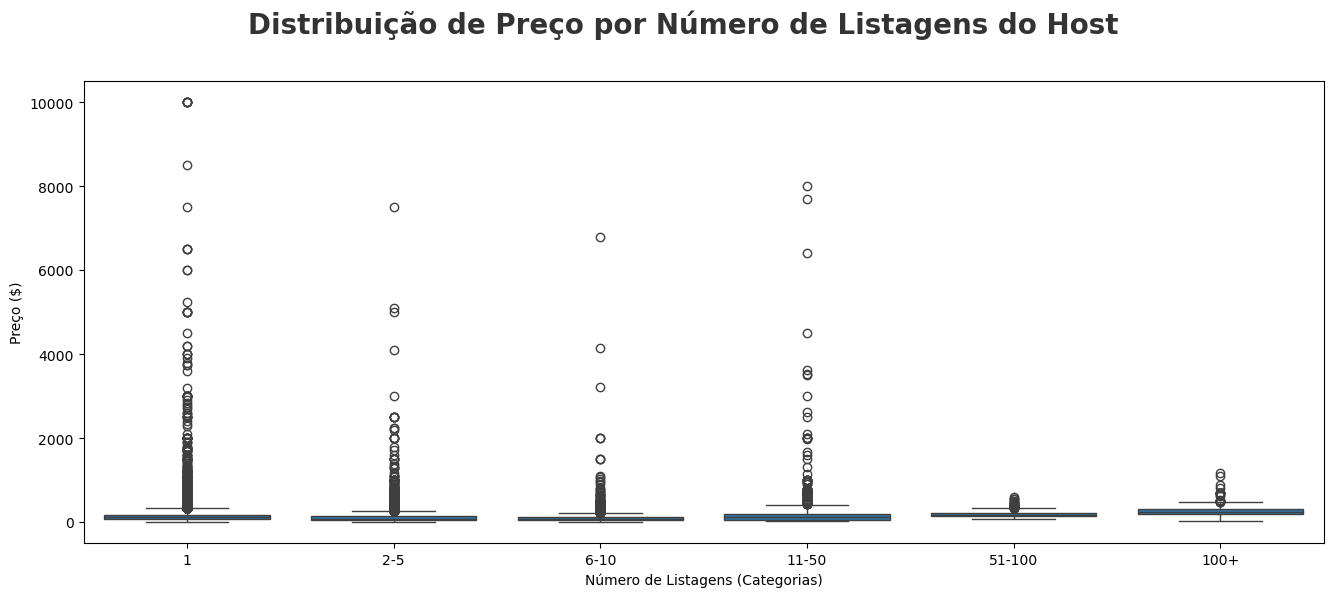

In [10]:
df['listings_category'] = pd.cut(df['calculado_host_listings_count'], bins=[0, 1, 5, 10, 50, 100, float('inf')], labels=['1', '2-5', '6-10', '11-50', '51-100', '100+'])
plt.figure(figsize=(16, 6))
sns.boxplot(x='listings_category', y='price', data=df)
plt.suptitle("Distribuição de Preço por Número de Listagens do Host", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('Número de Listagens (Categorias)')
plt.ylabel('Preço ($)')
plt.show()

Hosts com mais de 100 listagens parecem ter uma média de preços mais competitiva.

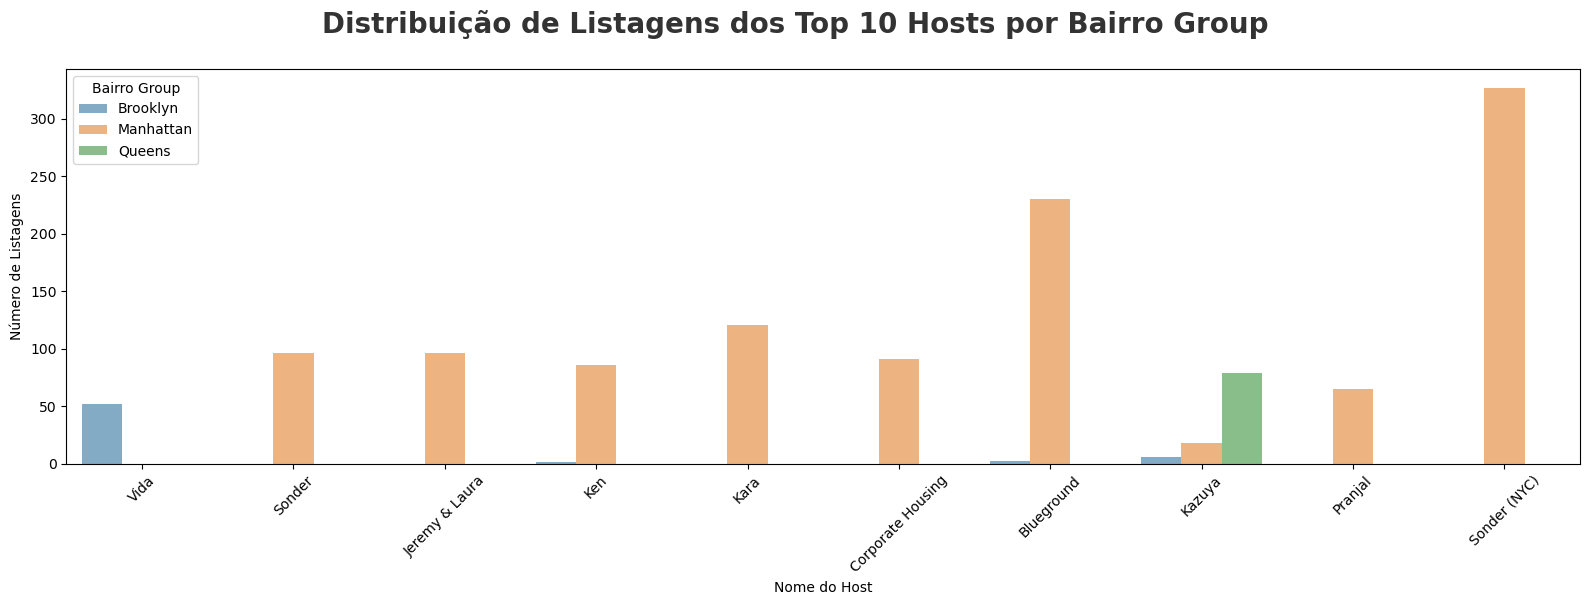

In [11]:
grouped = top_hosts_data.groupby(['host_id', 'bairro_group']).size().reset_index(name='num_listings')
grouped = grouped.merge(df[['host_id', 'host_name']].drop_duplicates(), on='host_id', how='left')
plt.figure(figsize=(16, 6))
sns.barplot(data=grouped, x='host_name', y='num_listings', hue='bairro_group', alpha=0.6)
plt.suptitle("Distribuição de Listagens dos Top 10 Hosts por Bairro Group", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('Nome do Host')
plt.ylabel('Número de Listagens')
plt.xticks(rotation=45)
plt.legend(title='Bairro Group')
plt.tight_layout()
plt.show()

A maioria dos tophosts estão concentrados em Manhattan. Alguns hosts, embora com menos listagens, exibem presença em diferentes bairros, indicando estratégia de diversificação.

Calculamos a média de preços dos nossos top hosts por tipo de quarto e identificamos o bairro predominante para cada host, com base no maior número de listagens. Em seguida, filtramos as listagens de hosts que não estão entre os top hosts, calculando a média de preços para esses bairros e tipos de quarto. Após isso, combinamos os dados, permitindo-nos comparar as médias de preços dos top hosts com as médias de preços dos bairros em que estão mais presentes.

In [12]:
media_preco_por_host = (
    top_hosts_data.groupby(['host_id', 'room_type'])['price']
    .mean()
    .reset_index(name='media_preco_host')
)
bairro_majoritario_por_host = (
    top_hosts_data.groupby(['host_id', 'bairro_group'])
    .size()
    .reset_index(name='contagem')
    .sort_values(['host_id', 'contagem'], ascending=[True, False])
    .drop_duplicates('host_id')
)
bairro_majoritario_por_host = bairro_majoritario_por_host.merge(
    df[['host_id', 'host_name']].drop_duplicates(),
    on='host_id',
    how='left'
)
bairro_majoritario_por_host = bairro_majoritario_por_host.merge(
    top_hosts_data[['host_id', 'room_type']].drop_duplicates(),
    on='host_id',
    how='left'
)
ids_top_hosts = top_hosts_data['host_id'].unique()
listings_sem_top_hosts = df[~df['host_id'].isin(ids_top_hosts)]
bairros_unicos = bairro_majoritario_por_host['bairro_group'].unique()
media_preco_por_bairro_e_room = (
    listings_sem_top_hosts[
        listings_sem_top_hosts['bairro_group'].isin(bairros_unicos)
    ]
    .groupby(['bairro_group', 'room_type'])['price']
    .mean()
    .reset_index(name='media_preco_bairro_room')
)
comparacao = (
    bairro_majoritario_por_host
    .merge(media_preco_por_host, on=['host_id', 'room_type'])
    .merge(media_preco_por_bairro_e_room, on=['bairro_group', 'room_type'])
)

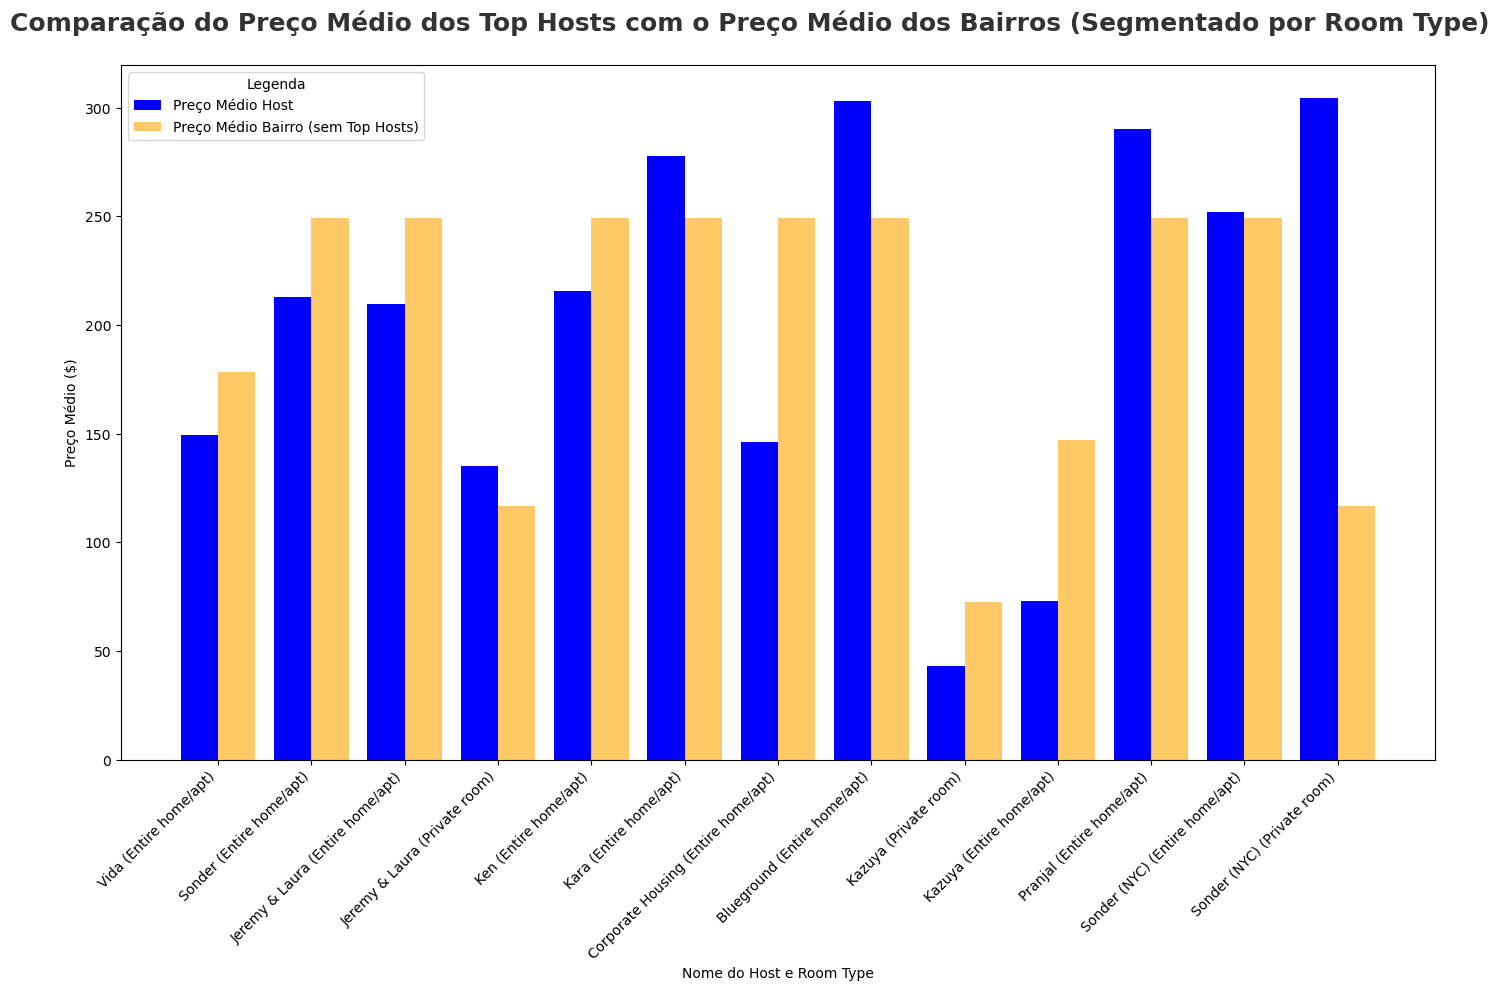

In [13]:
plt.figure(figsize=(14, 10))
x = range(len(comparacao))
width = 0.4
plt.bar(
    [pos - width / 2 for pos in x],
    comparacao['media_preco_host'],
    width=width,
    color='blue',
    label='Preço Médio Host'
)
plt.bar(
    [pos + width / 2 for pos in x],
    comparacao['media_preco_bairro_room'],
    width=width,
    color='orange',
    alpha=0.6,
    label='Preço Médio Bairro (sem Top Hosts)'
)
plt.xticks(
    x,
    comparacao.apply(lambda row: f"{row['host_name']} ({row['room_type']})", axis=1),
    rotation=45,
    ha='right'
)
plt.suptitle("Comparação do Preço Médio dos Top Hosts com o Preço Médio dos Bairros (Segmentado por Room Type)", fontsize=18, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('Nome do Host e Room Type')
plt.ylabel('Preço Médio ($)')
plt.legend(title='Legenda')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

Inicialmente, propusemos que hosts com portfólios maiores teriam preços mais competitivos devido às estratégias de economia de escala. Essa hipótese foi baseada na suposição de que a diluição dos custos operacionais e a experiência acumulada dos hosts permitiriam preços mais baixos por listagem.

No entanto, a análise revelou que essa hipótese só vale até certo ponto: dentre os hosts com portfólios maiores (tophosts), os cinco maiores tendem a apresentar preços médios mais elevados em comparação aos hosts com menos listagens. Esse resultado não necessariamente contradiz a hipótese inicial, já que ela ainda vale para os cinco menores entre os 10 hosts com mais listagens, mas sugere que outros fatores estão em jogo.

Uma possível explicação para esse padrão é que tophosts frequentemente oferecem acomodações em localizações mais valorizadas ou com melhores comodidades, permitindo-lhes cobrar preços mais altos. Além disso, a reputação e a experiência acumulada desses hosts podem justificar um prêmio de preço percebido pelos hóspedes. Dessa forma, os custos mais elevados podem não ser uma barreira, mas sim um reflexo da alta qualidade ou do nicho de mercado que atendem.


## Continuando

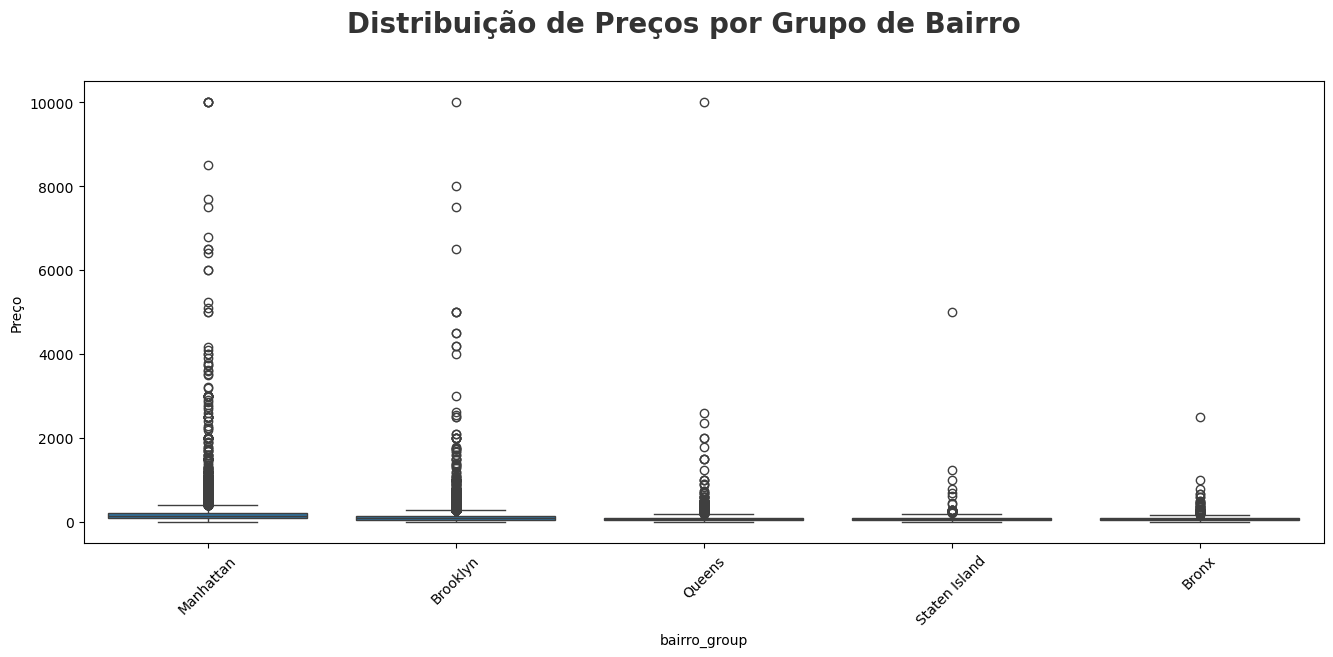

In [14]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='bairro_group', y='price', data=df)
plt.suptitle("Distribuição de Preços por Grupo de Bairro", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('bairro_group')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

Como era esperado, os preços mais altos se encontram em Manhattan e os outliers mais extremos se encontram divididos entre Manhattan, Brooklyn e o Queens, sendo os três grupos com maior amplitude de preços, desde os mais baixos até os mais altos. Em contraponto, áreas como Staten Island e Bronx apresentam uma distribuição de preços mais concentrada em faixas mais baixas, sugerindo menor variação nos custos de hospedagem. Apesar dessas diferenças, todos os grupos possuem outliers.

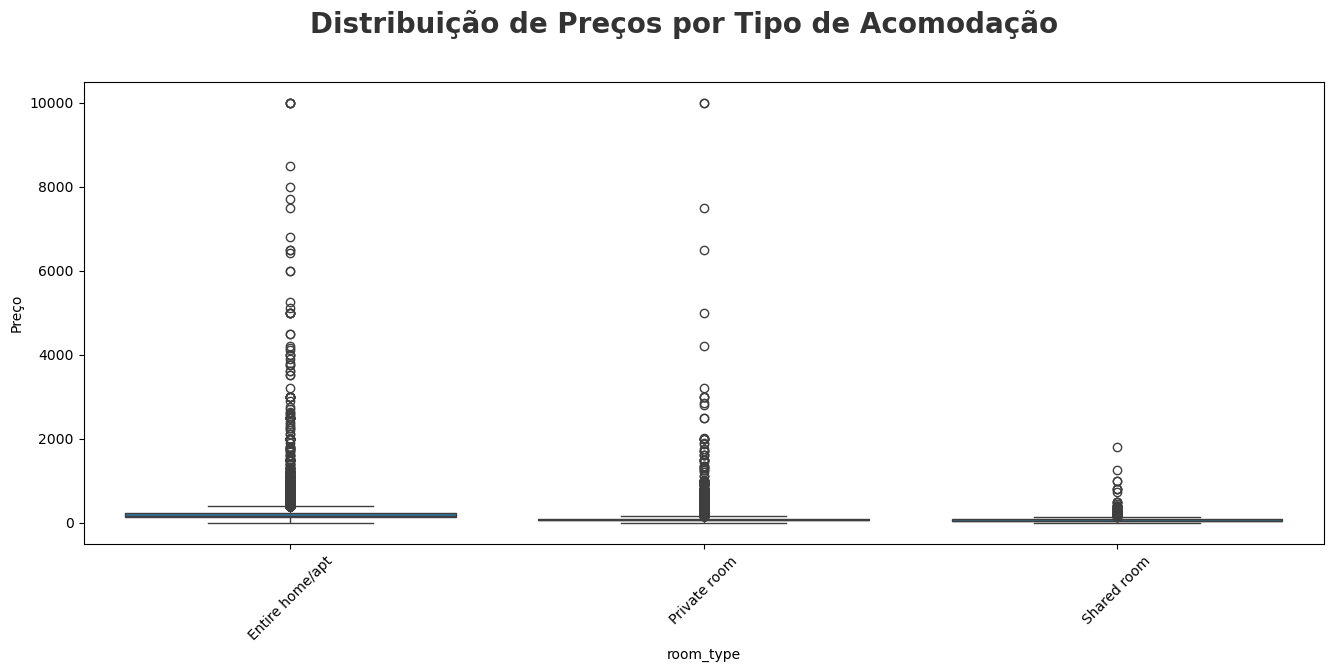

In [15]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.suptitle("Distribuição de Preços por Tipo de Acomodação", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('room_type')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

Há uma variação notável nas tarifas cobradas para cada tipo de acomodação. Observa-se que as acomodações inteiras, como casas ou apartamentos, apresentam uma maior dispersão de preços em comparação com quartos privados ou compartilhados. Os outliers se concentram principalmente nas acomodação do tipo `Entire home/apt` e `Private room`. Já os quartos compartilhados, conforme esperado, mantêm-se em uma faixa de preço mais uniforme e acessível, provavelmente devido à menor privacidade e flexibilidade nas acomodações.

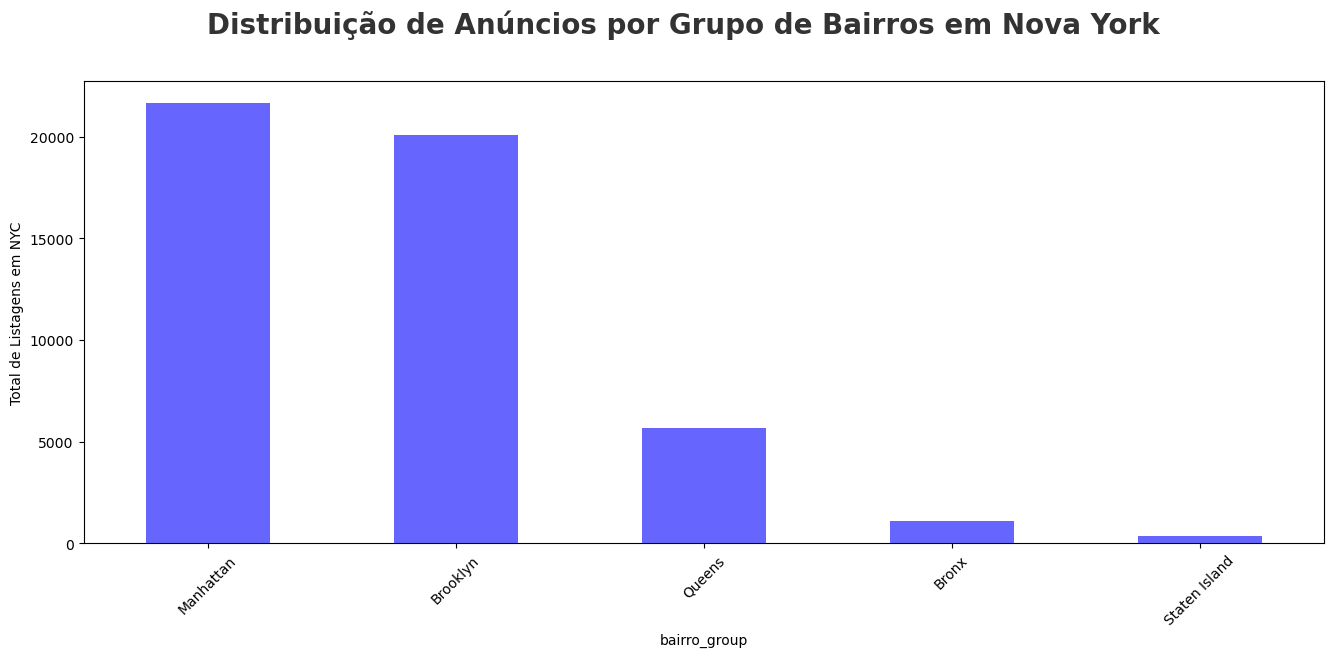

In [16]:
plt.figure(figsize=(16, 6))
df['bairro_group'].value_counts().plot(kind='bar', color='b', alpha=0.6)
plt.suptitle("Distribuição de Anúncios por Grupo de Bairros em Nova York", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('bairro_group')
plt.ylabel('Total de Listagens em NYC')
plt.xticks(rotation=45)
plt.show()

A distribuição de listagens por grupo de bairros acompanha a distribuição de preços, denotando uma concentração muito expressiva em Manhattan e Brooklyn, o que indica uma alta demanda muito provavelmente devida ao fato de serem duas regiões de grande valor turístico.

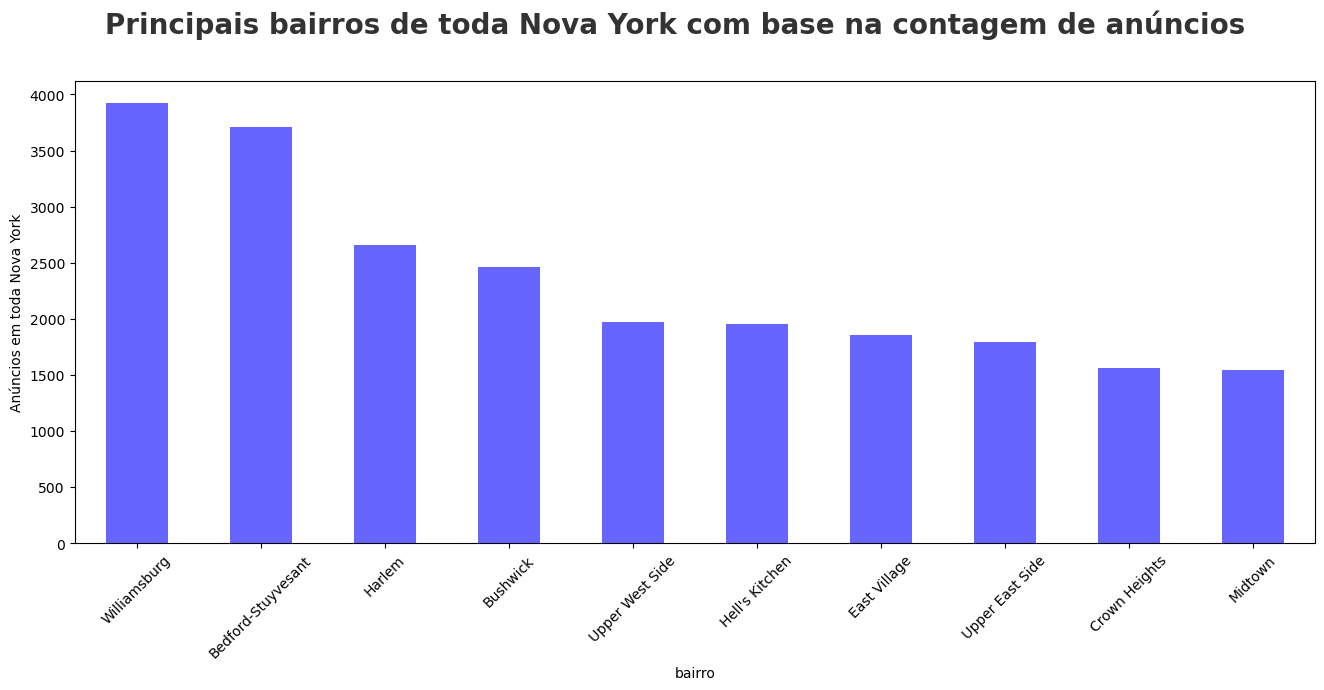

In [17]:
plt.figure(figsize=(16, 6))
top_10_neigbours = df['bairro'].value_counts()[:10]
top_10_neigbours.plot(kind='bar', color='b', alpha=0.6)
plt.suptitle("Principais bairros de toda Nova York com base na contagem de anúncios", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('bairro')
plt.ylabel('Anúncios em toda Nova York')
plt.xticks(rotation=45)
plt.show()

Williamsburg e Bedford-Stuyvesant lideram o ranking de anúncios, evidenciando alta popularidade entre os anfitriões. Seguem-se Harlem, Bushwick e Upper West Side, que também apresentam um número expressivo de anúncios. Essa distribuição sugere que essas áreas são atrativas tanto para viajantes quanto para locatários de curto prazo. Por outro lado, o número de anúncios em cada bairro não passa de 10% do número total de anúncios, indicando que a distribuição pode ser bem mais uniforme do que é visível à primeira vista. Uma análise geográfica mais visual demonstra-rá isso mais abaixo.

## Investigando e Tratando Outliers
Exploraremos os dados em busca de valores atípicos que possam influenciar negativamente nossas análises. Iremos identificá-los e aplicar técnicas adequadas para tratá-los, a fim de garantir a integridade e a precisão das informações subsequentes.



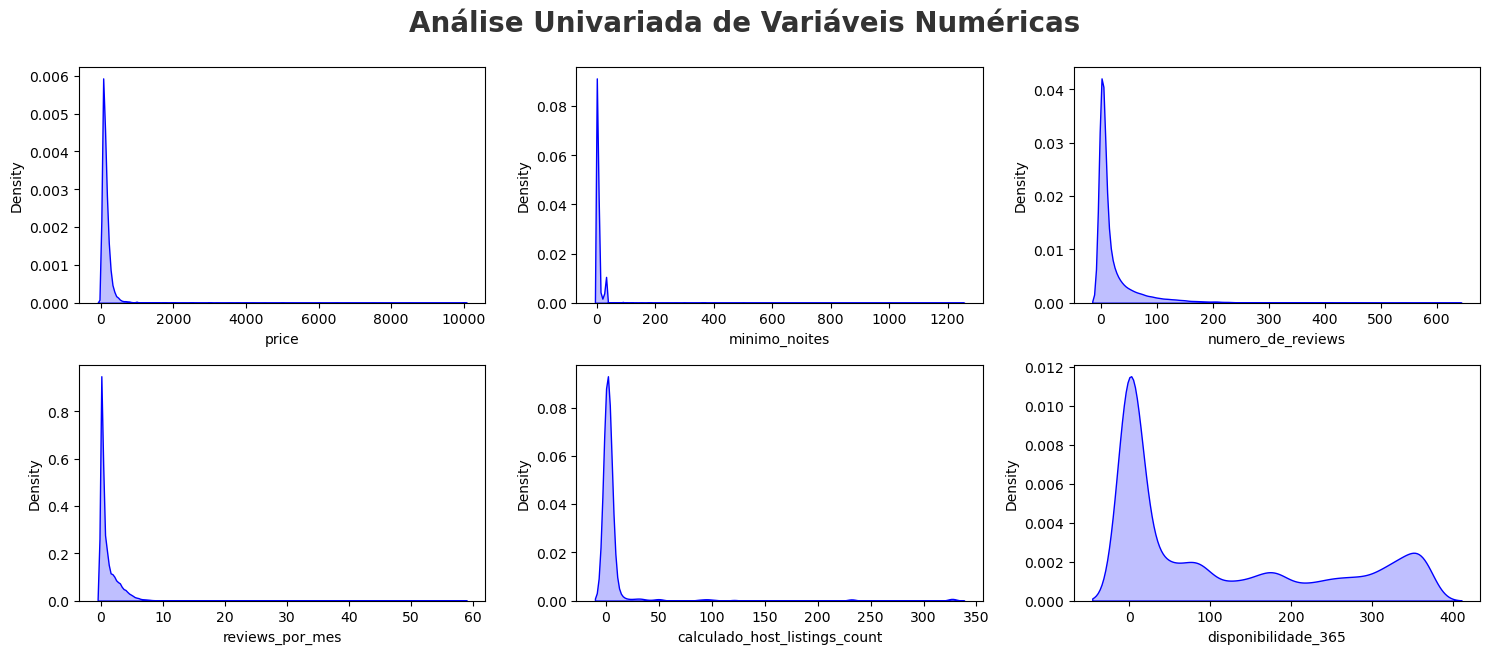

In [18]:
plt.figure(figsize=(15,15))
plt.suptitle("Análise Univariada de Variáveis Numéricas", fontsize=20, fontweight="bold", alpha=0.8, y=1)
for i in range(len(variaveis_numericas)):
  plt.subplot(5,3,i+1)
  sns.kdeplot(df[variaveis_numericas[i]], fill=True, color='b')
  plt.xlabel(variaveis_numericas[i])
  plt.tight_layout()

Todas as variáveis numéricas apresentam um viés à direita, demonstrando que há outliers positivamente extremos, enquanto a maioria dos dados se concentra em valores sempre mais próximos do mínimo, ou seja, a maioria das hospedagens é acessível, com estadias mínimas curtas e poucos reviews, refletindo um mercado dominado por anúncios pequenos e menos revisados. No entanto, as longas caudas nas distribuições de "price" e "calculado_host_listings_count" sugerem a presença de algumas opções premium e anfitriões profissionais, como nós já averiguamos acima. A variabilidade na "disponibilidade_365", por sua vez, reflete estratégias distintas de disponibilidade, possivelmente influenciadas por sazonalidade ou políticas individuais dos anfitriões.

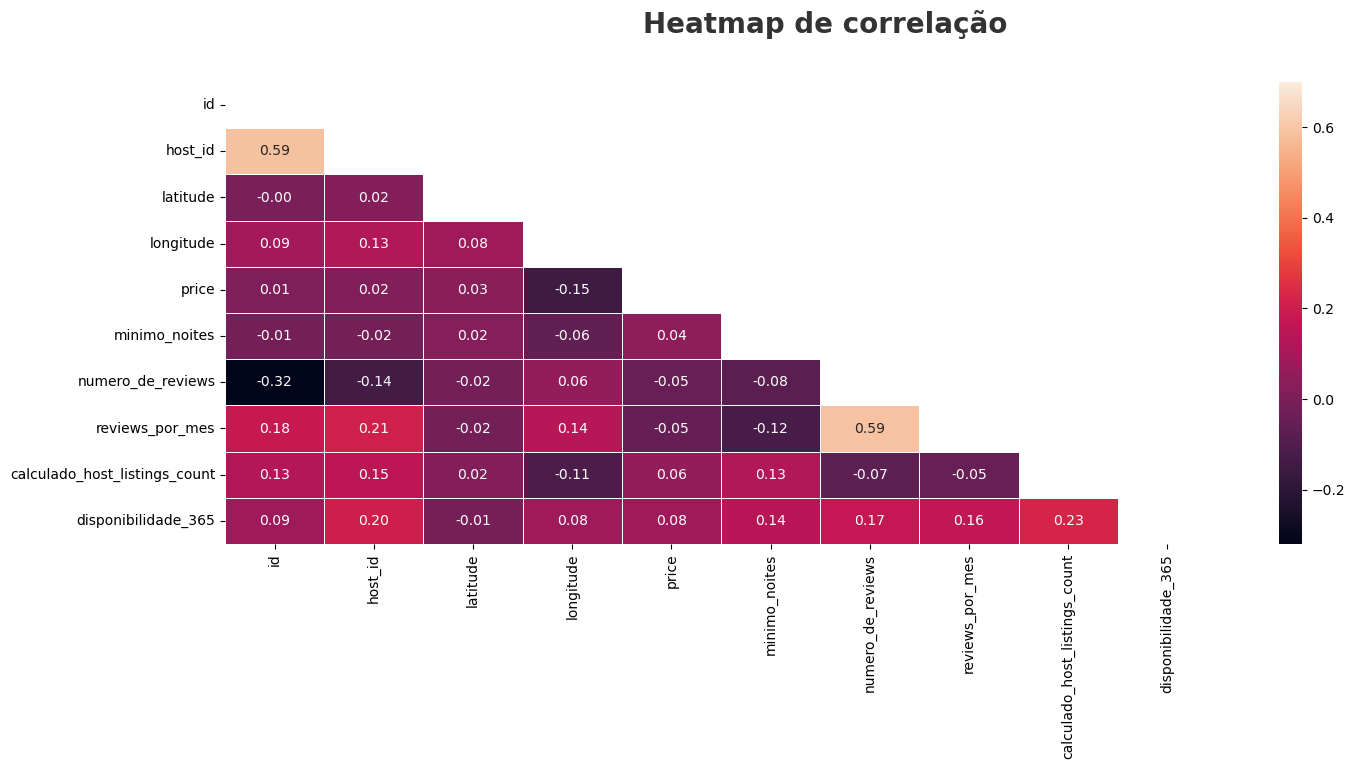

In [19]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(16, 6))
dropSelf = np.zeros_like(correlation_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(correlation_matrix, vmax=.7, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.suptitle("Heatmap de correlação", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.show()

A matriz de correlação acima não demonstra nenhuma correlação muito forte as variáveis, além das mais óbvias, como `numero_de_reviews` e `reviews_por_mes`, o que indica que os fatores não costumam afetar uns aos outros de forma linear. A correlação negativa entre `id` e `numero_de_reviews` muito provavelmente se deve ao formato desses dois valores, sendo um muito pequeno e outro muito grande.

A matriz acima aponta que não há correlação entre `disponibilidade_365` e `price`, bem como não há correlação entre `minimo_noite` e `price`.
Os gráficos abaixo permitem uma melhor visualização.

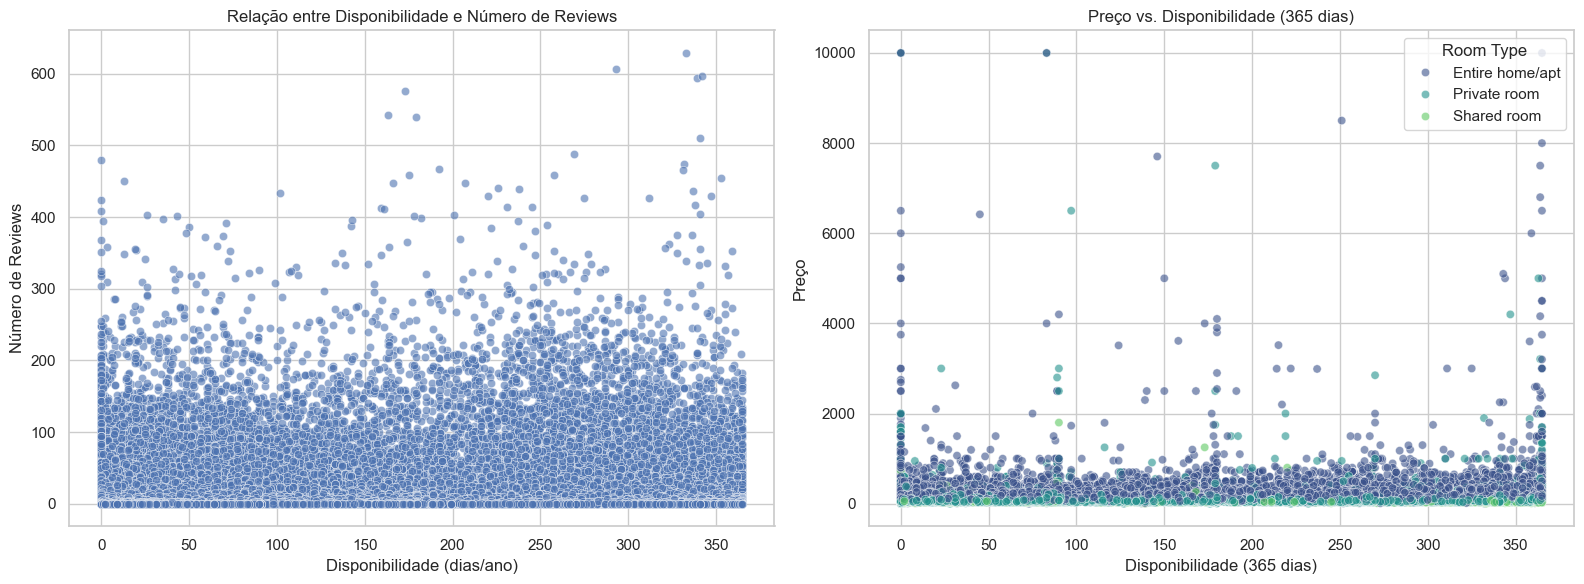

In [20]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=df, x='disponibilidade_365', y='numero_de_reviews', alpha=0.6, ax=axes[0])
axes[0].set_title('Relação entre Disponibilidade e Número de Reviews')
axes[0].set_xlabel('Disponibilidade (dias/ano)')
axes[0].set_ylabel('Número de Reviews')
sns.scatterplot(
    data=df,
    x='disponibilidade_365',
    y='price',
    hue='room_type',
    alpha=0.6,
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Preço vs. Disponibilidade (365 dias)')
axes[1].set_xlabel('Disponibilidade (365 dias)')
axes[1].set_ylabel('Preço')
axes[1].legend(title='Room Type', loc='upper right')
plt.tight_layout()
plt.show()

In [21]:
listagens_10000 = df[df['price'] == 10000]
display(listagens_10000)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,listings_category
9150,7003697,Furnished room in Astoria apartment,20582832,Kathrine,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,2016-02-13,0.04,1,0,1
17691,13894339,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Erin,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,2017-07-27,0.16,1,0,1
29237,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaT,0.00,1,83,1


In [22]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iiq = q3 - q1

limite_inferior = q1 - 1.5 * iiq
limite_superior = q3 + 1.5 * iiq

df_outliers = df[(df['price'] < limite_inferior) | (df['price'] > limite_superior)]
df_filtrado = df[(df['price'] >= limite_inferior) & (df['price'] <= limite_superior)]

num_outliers = df_outliers.shape[0]

print(f"Número de outliers: {num_outliers}")

Número de outliers: 2972


Aqui utilizamos o método do intervalo interquartil (IQR) para identificar e tratar outliers na variável `price`. O IQR é uma abordagem robusta para detectar valores anômalos ao calcular a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1), estabelecendo limites inferiores e superiores para trabalhar com outliers. Dessa forma segmentando o conjunto de dados original em dois conjuntos distintos: um para os dados mais próximos da norma e um para os dados que fogem à norma (os outliers).
O objetivo é garantir que os dados filtrados sejam mais representativos e menos influenciados por valores extremos.

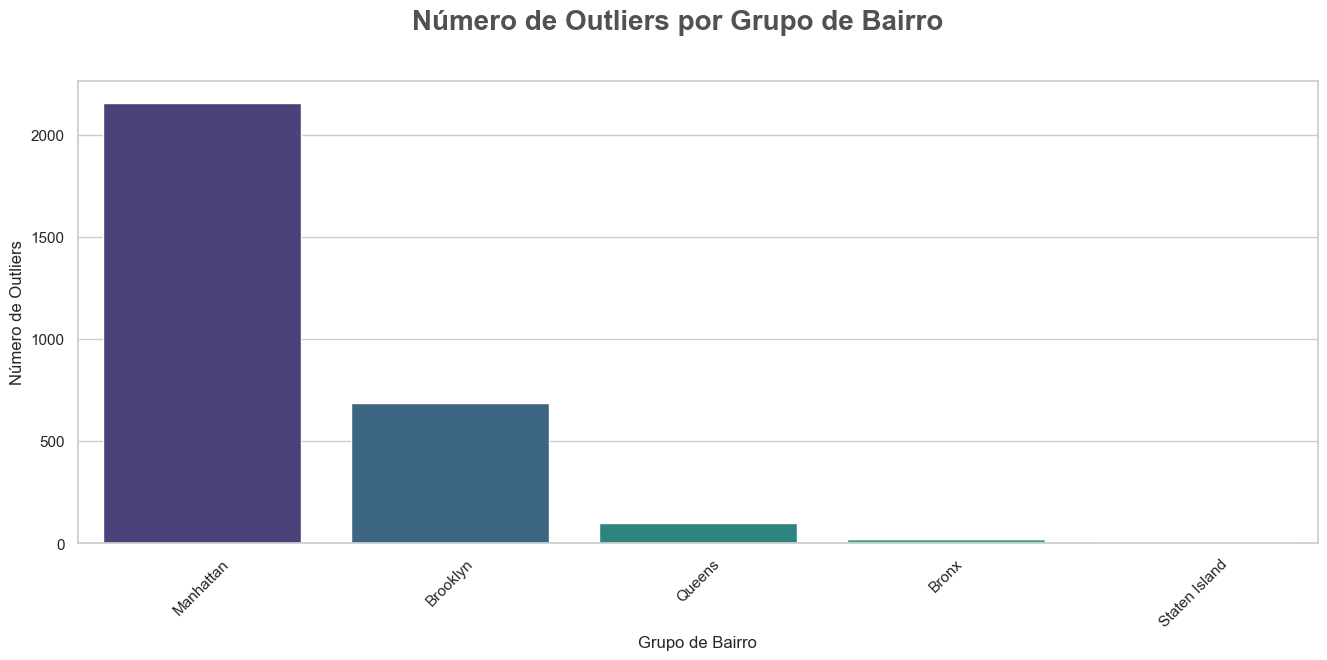

In [23]:
outliers_por_gb = df_outliers['bairro_group'].value_counts()
plt.figure(figsize=(16, 6))
sns.barplot(x=outliers_por_gb.index, hue=outliers_por_gb.index, y=outliers_por_gb.values, palette="viridis")
plt.suptitle("Número de Outliers por Grupo de Bairro", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.ylabel('Número de Outliers')
plt.xlabel('Grupo de Bairro')
plt.xticks(rotation=45)
plt.show()

Aqui percebemos que Manhattan concentra o maior número de outliers, se destacando significativamente em relação a outros bairros. Isso sugere que nesta região há uma alta presença de listagens com características excepcionais, provavelmente refletindo opções premium e anfitriões profissionais. Brooklyn também apresenta uma quantidade considerável de outliers, mas bem menor que Manhattan. Já Queens, Bronx e Staten Island possuem poucos outliers, sugerindo um mercado mais homogêneo nessas áreas.

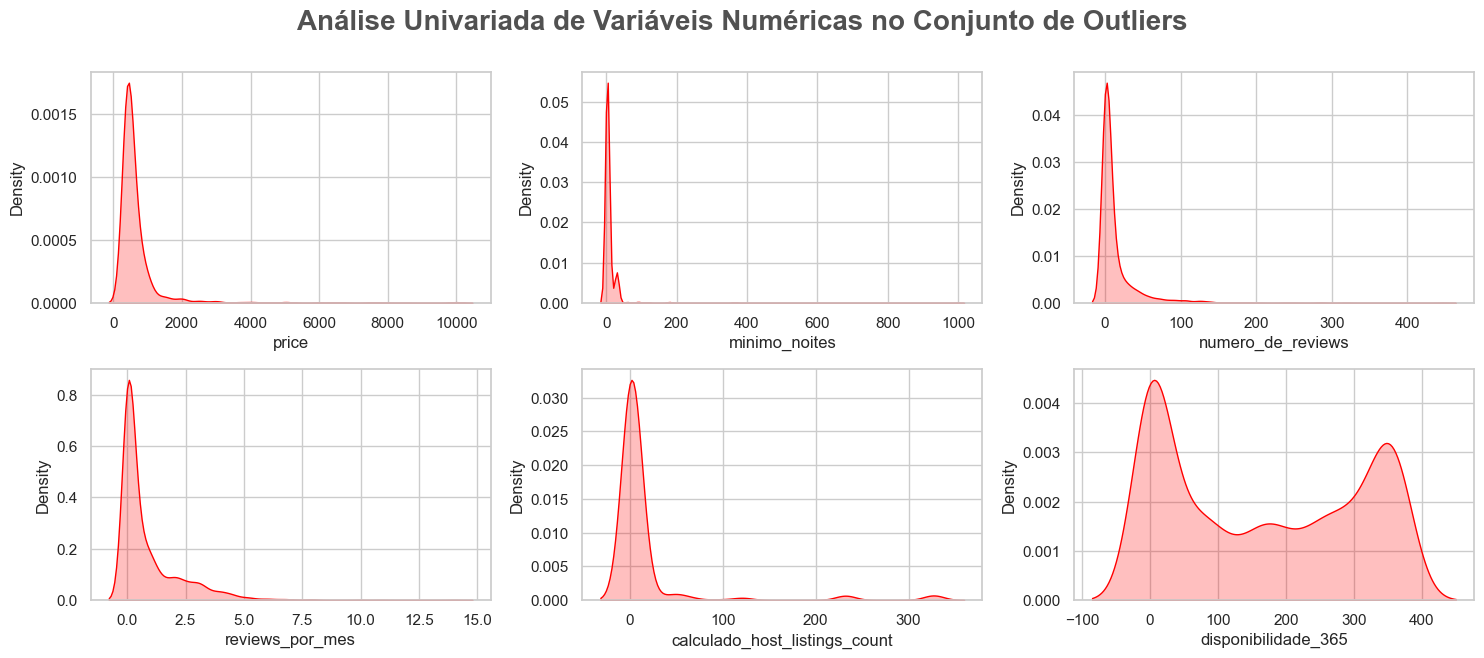

In [24]:
plt.figure(figsize=(15,15))
plt.suptitle("Análise Univariada de Variáveis Numéricas no Conjunto de Outliers", fontsize=20, fontweight="bold", alpha=0.8, y=1)
for i in range(len(variaveis_numericas)):
  plt.subplot(5,3,i+1)
  sns.kdeplot(df_outliers[variaveis_numericas[i]], fill=True, color='red')
  plt.xlabel(variaveis_numericas[i])
  plt.tight_layout()

No que diz respeito à distribuição das variáveis numéricas no conjunto de outliers, a distribuição de "price" ainda mostra viés à direita, mas com maior concentração em valores elevados, confirmando a presença de opções premium. `mínimo_noites` e `número_de_reviews` também mantêm a tendência, mas com caudas mais acentuadas, sugerindo algumas listagens com estadias mínimas extensivas e reviews abundantes. `reviews_por_mes` reforça a ideia de que a popularidade de algumas listagens estão ligadas ao seu preço. A distribuição de `disponibilidade_365` difere da do conjunto original, exibindo picos em disponibilidade completa e restrita, sinalizando estratégias extremas de oferta. Este conjunto indica que outliers têm padrões distintos, focando em características de exclusividade e alto serviço. De forma geral, porém, pode-se dizer que o conjunto de outliers segue o mesmo padrão, em relação às variáveis numéricas, que o conjunto de dados geral apresenta.

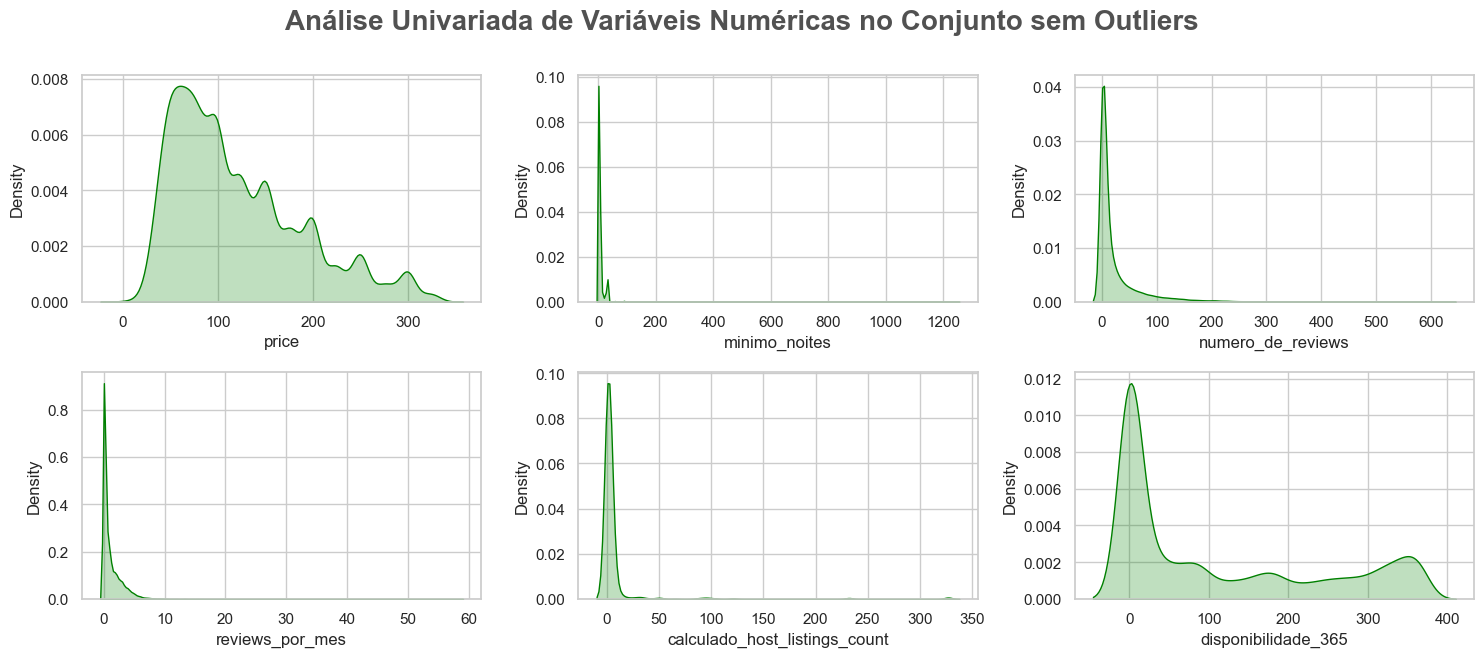

In [25]:
plt.figure(figsize=(15,15))
plt.suptitle("Análise Univariada de Variáveis Numéricas no Conjunto sem Outliers", fontsize=20, fontweight="bold", alpha=0.8, y=1)
for i in range(len(variaveis_numericas)):
  plt.subplot(5,3,i+1)
  sns.kdeplot(df_filtrado[variaveis_numericas[i]], fill=True, color='green')
  plt.xlabel(variaveis_numericas[i])
  plt.tight_layout()

A análise dos dados sem os outliers mostra dados da variável `price` mais concentrados em valores modestos, com uma distribuição quase normal, sendo a maioria dos dados em torno 100. Todas as outras variáveis, porém, apresentam a exata mesma distribuição que apresentam na análise para o conjunto geral de dados, o que reforça ainda mais que os outliers de preço não estão ligados aos outliers das outras variáveis.

In [26]:
display(df_filtrado[variaveis_numericas].describe())

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,45922.000000,45922.00000,45922.000000,45922.000000,45922.000000,45922.000000
mean,119.969688,6.93820,23.942990,1.107758,6.639715,109.373133
std,68.150755,19.85802,45.315659,1.612669,31.008486,130.275350
min,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000
25%,65.000000,1.00000,1.000000,0.050000,1.000000,0.000000
50%,100.000000,2.00000,5.000000,0.380000,1.000000,39.000000
75%,159.000000,5.00000,24.000000,1.620000,2.000000,217.000000
max,334.000000,1250.00000,629.000000,58.500000,327.000000,365.000000


Ao comparar os resumos estatísticos dos conjuntos sem outliers e geral, percebe-se que a remoção dos outliers reduziu a média da variável `price` de 152.72 para 119.97, indicando que os outliers eram de fato mais caros. O desvio padrão também diminuiu, reforçando a visão de um mercado mais uniforme sem as influências extremas. As estatísticas de `minimo_noites` e `numero_de_reviews`, por outro lado, permaneceram estáveis, demonstrando que outliers não impactaram significativamente essas variáveis. `reviews_por_mes` teve um leve aumento na média e nos quartis, apontando uma consistência na frequência de avaliações, o que é de se esperar, visto que acomodações mais caras podem ter menos avaliações. Já a variável `disponibilidade_365` reduziu levemente sua média, ou seja, alguns outliers tinham disponibilidade maior que a média.

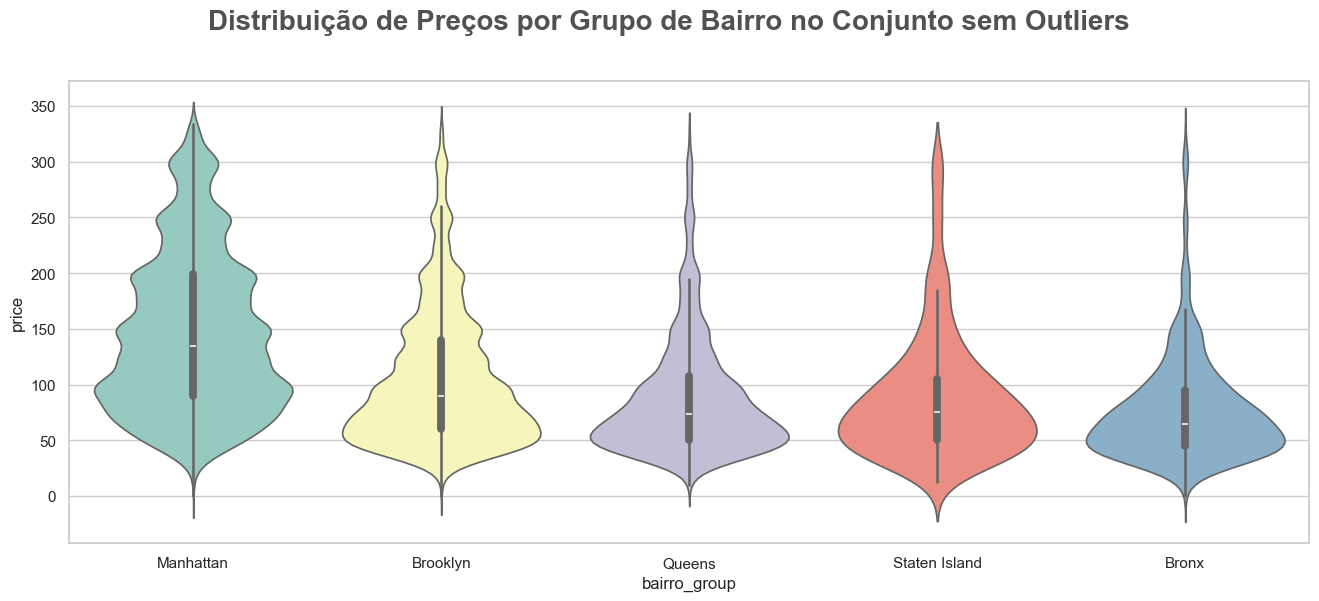

In [27]:
plt.figure(figsize=(16, 6))
plt.suptitle("Distribuição de Preços por Grupo de Bairro no Conjunto sem Outliers", fontsize=20, fontweight="bold", alpha=0.8, y=1)
ax= sns.violinplot(x='bairro_group', y='price', hue='bairro_group', data=df_filtrado, palette='Set3')

A partir dessa distribuição, podemos verificar como os preços variam conforme o grupo de bairro. Manhattan e Brooklyn têm preços mais elevados, mas com ampla distribuição, o que indica variedade de opções, mas ainda mantendo uma faixa superior à de outros bairros. Queens, Bronx e Staten Island exibem distribuições mais estreitas e valores medianos menores, sugerindo uma oferta mais acessível e homogênea. A forma das distribuições reflete as características econômicas e de demanda de cada região, mais uma vez reafirmando Manhattan e Brooklyn como mercados mais caros e diversificados. A média de preços por grupo de bairro segue a mesma tendência da distribuição, conforme demonstrado no gráfico abaixo.

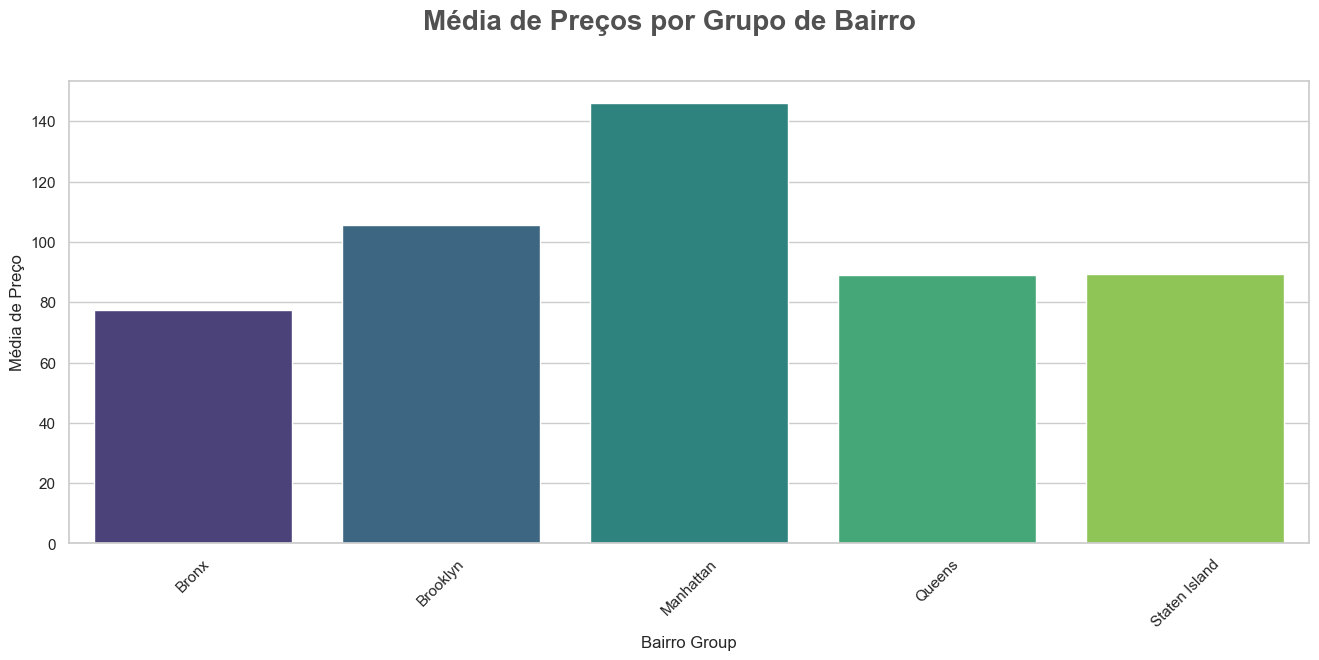

In [28]:
media_precos_bairro = df_filtrado.groupby('bairro_group')['price'].mean().reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(x='bairro_group', y='price', hue='bairro_group', data=media_precos_bairro, palette='viridis')
plt.suptitle("Média de Preços por Grupo de Bairro", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('Bairro Group')
plt.ylabel('Média de Preço')
plt.xticks(rotation=45)
plt.show()

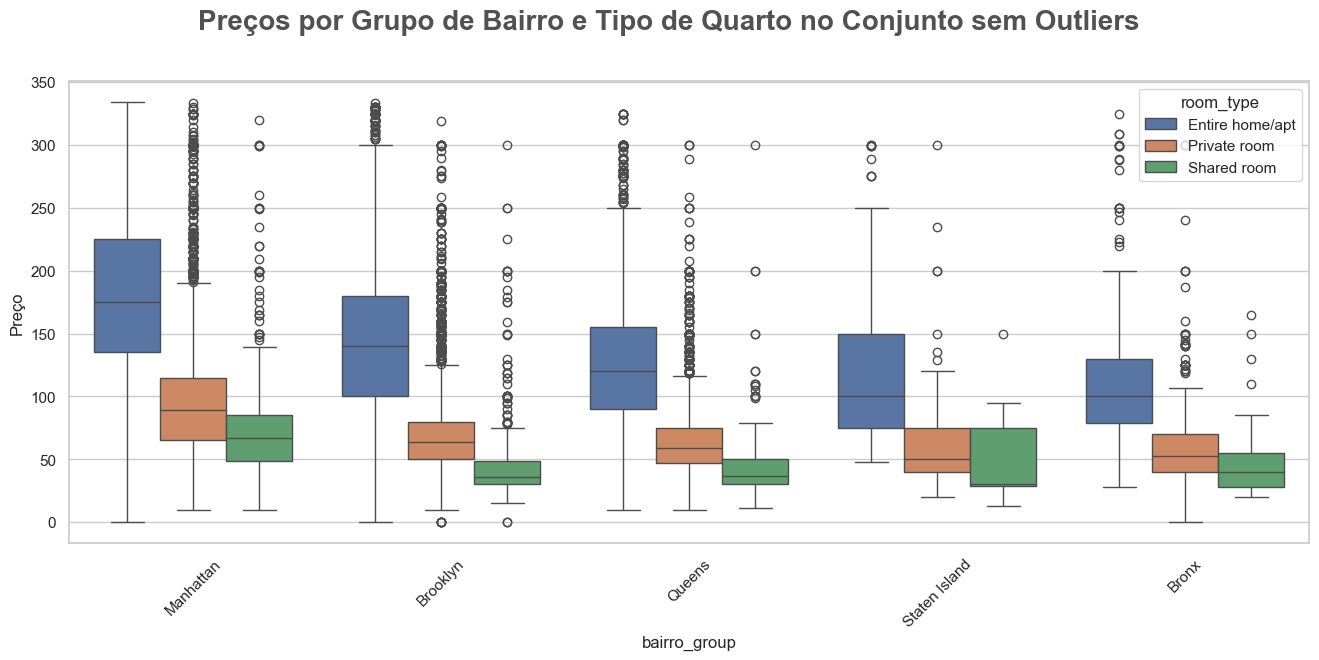

In [29]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='bairro_group', y='price', hue='room_type', data=df_filtrado)
plt.suptitle("Preços por Grupo de Bairro e Tipo de Quarto no Conjunto sem Outliers", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

 Em todos os bairros, "Entire home/apt" é a opção mais cara, especialmente em Manhattan, onde a mediana parece ficar em torno de 200 dólares. "Private room" tem preços medianos mais baixos, enquanto "Shared room" é a opção mais econômica. Manhattan e Brooklyn mantêm os preços mais altos em todas as categorias, refletindo sua posição como mercados mais premium. Queens, Bronx, e Staten Island apresentam preços medianos mais equilibrados e acessíveis, especialmente para "Shared room".

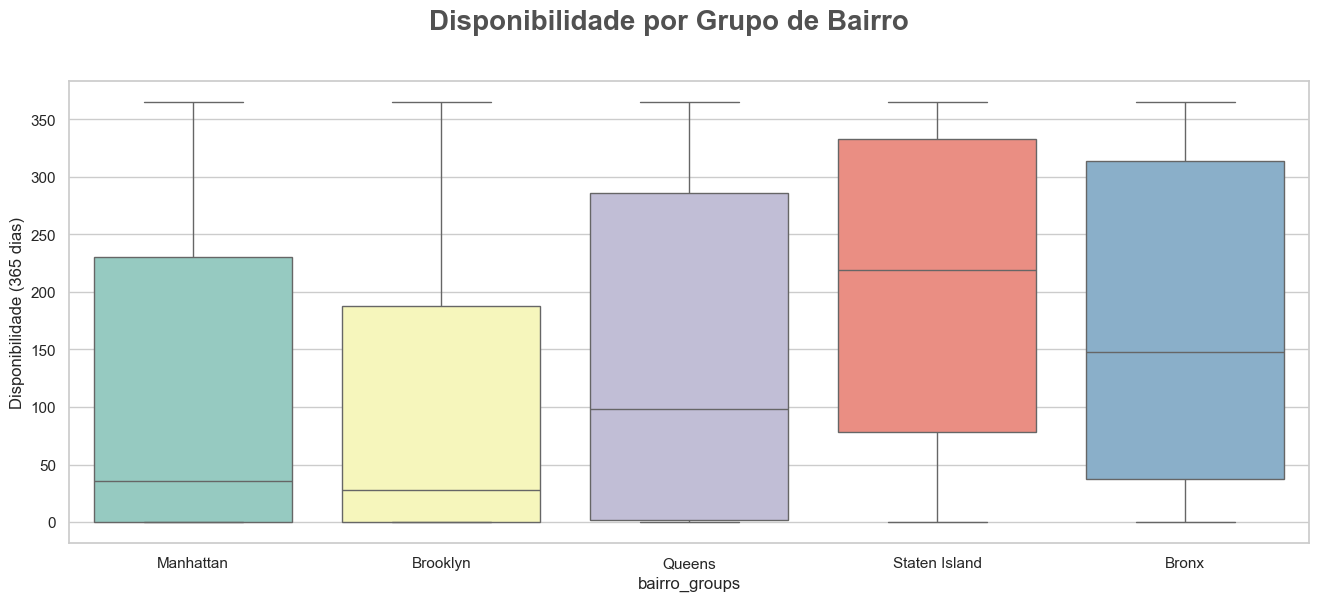

In [30]:
f,ax = plt.subplots(figsize=(16,6))
ax=sns.boxplot(x='bairro_group', y='disponibilidade_365', hue='bairro_group', data=df, palette='Set3')
plt.suptitle("Disponibilidade por Grupo de Bairro", fontsize=20, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('bairro_groups')
plt.ylabel('Disponibilidade (365 dias)')
plt.show()

Aqui notamos que Staten Island e Bronx possuem as maiores medianas de disponibilidade, indicando que muitas listagens estão frequentemente disponíveis ao longo do ano. Em Manhattan e Brooklyn, porém, a disponibilidade tende a ser menor, muito provavelmente devido à alta demanda contínua. Queens exibe uma distribuição intermediária.

### Como temos `latidude` e `longitude`, podemos visualizar a distribuição geográfica das listagens em um mapa

Text(0.5, 1, 'Coordenadas de Localização')

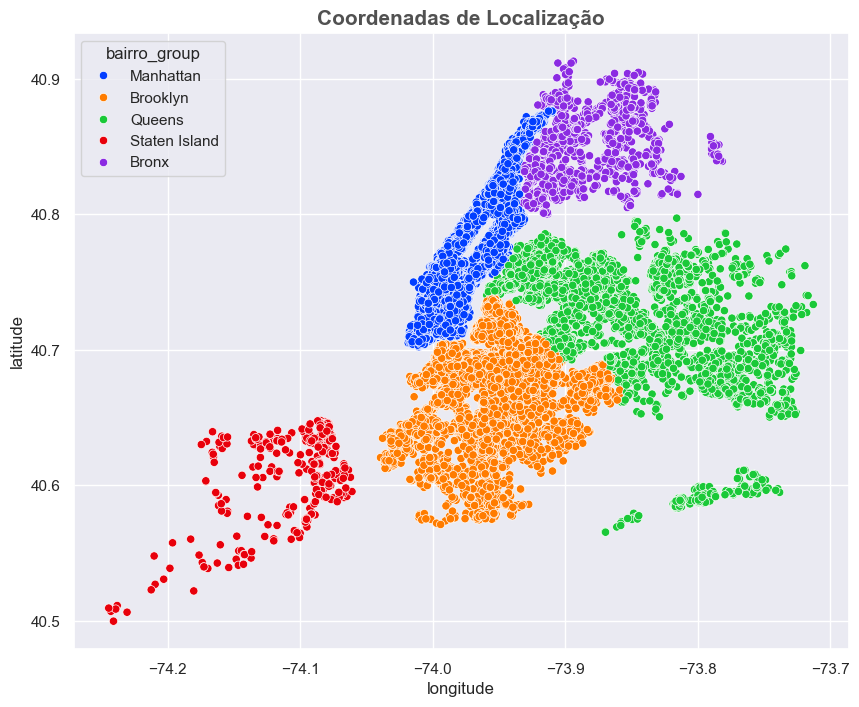

In [31]:
sns.set(rc={"figure.figsize": (10, 8)})
ax= sns.scatterplot(data=df, x="longitude", y="latitude",hue='bairro_group',palette='bright')
ax.set_title("Coordenadas de Localização", fontsize=15, fontweight="bold", alpha=0.8, y=1)

Text(0.5, 1, 'Distribuição dos tipos de quartos em Nova York')

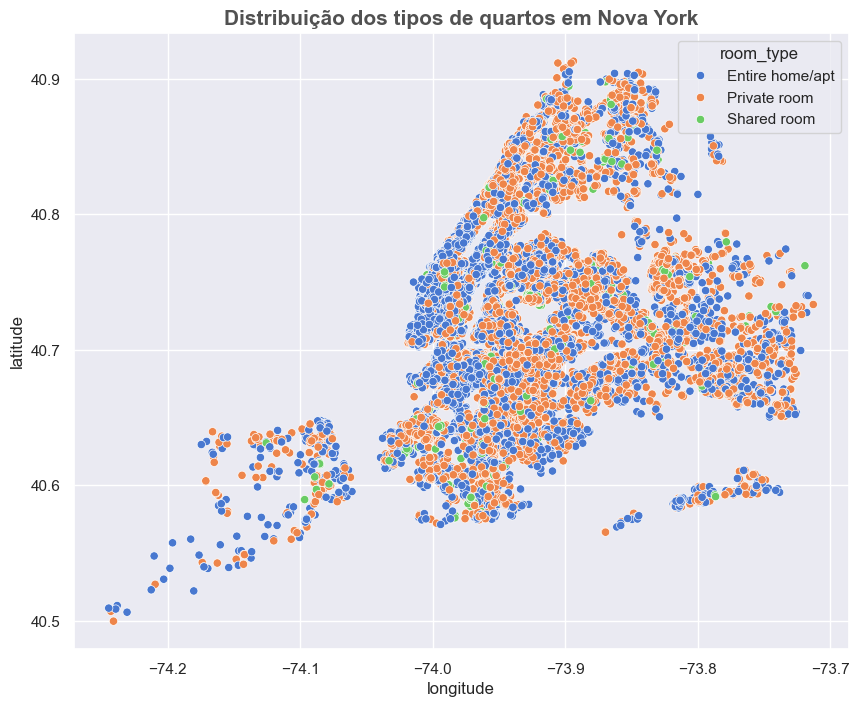

In [32]:
sns.set(rc={"figure.figsize": (10, 8)})
ax= sns.scatterplot(x=df.longitude, y=df.latitude,hue=df.room_type,palette='muted')
ax.set_title("Distribuição dos tipos de quartos em Nova York", fontsize=15, fontweight="bold", alpha=0.8, y=1)

### Vamos agora explorar os padrões nos nomes de cada listagem

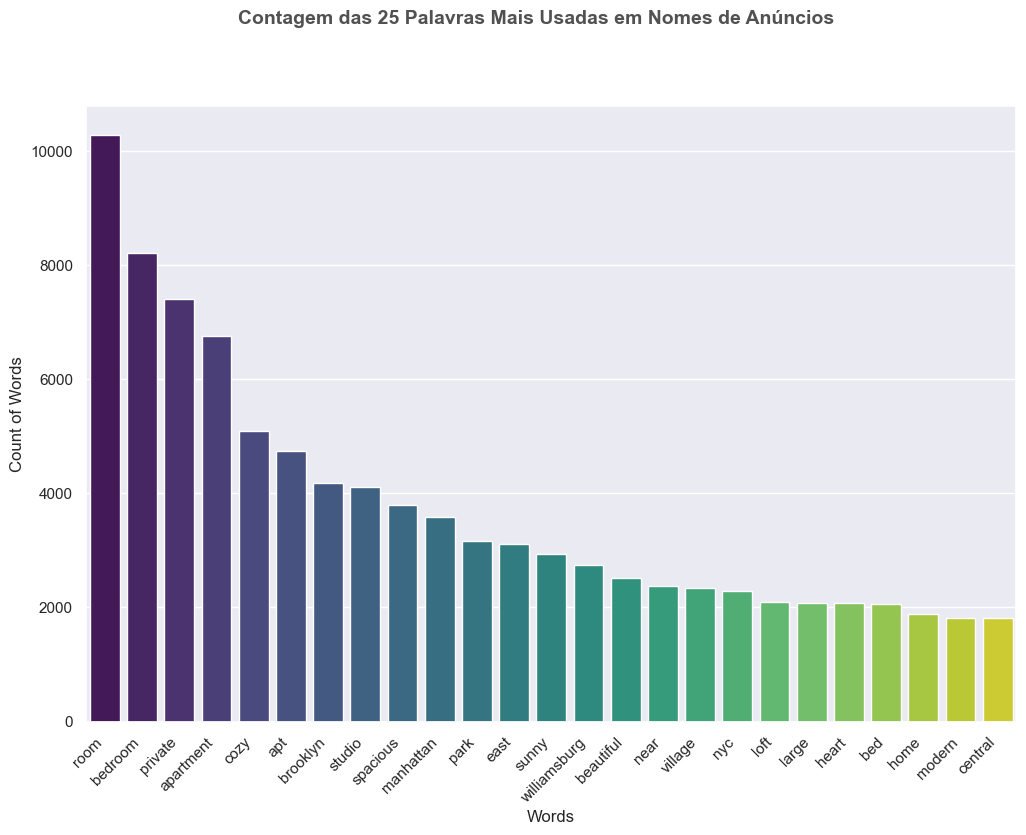

In [33]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['nome'].dropna())
word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
top_words_df = word_freq_df.sort_values('count', ascending=False).head(25)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, x='word', y='count', hue='word', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.suptitle("Contagem das 25 Palavras Mais Usadas em Nomes de Anúncios", fontsize=14, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('Words')
plt.ylabel('Count of Words')
plt.show()

Termos como "room", "bedroom", "private" e "apartment" são os mais comuns, o que indica foco em características de acomodação. Palavras como "cozy" e "spacious" indicam a tentativa de atrair hóspedes com base em características como conforto e tamanho, enquanto "brooklyn" e "manhattan" destacam localizações populares.

#### Agora vamos explorar os padrões nos nomes das listagens de mais alto valor

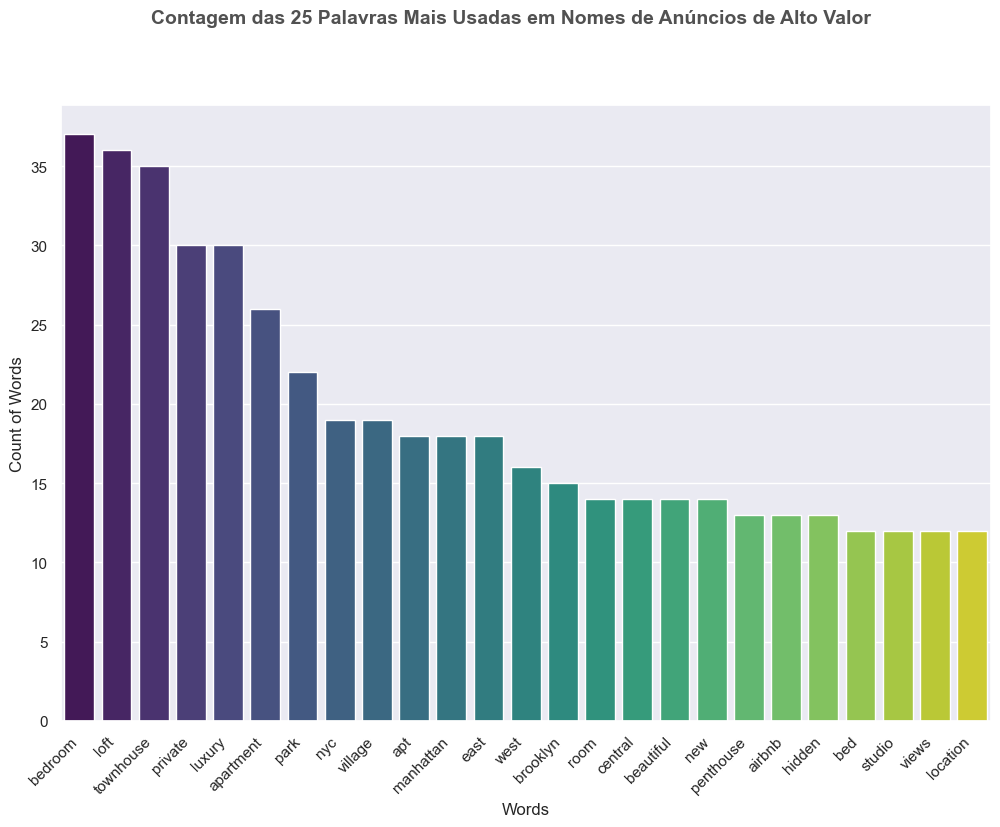

In [34]:
df_alto_valor = df[df['price'] >= 1000]
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_alto_valor['nome'].dropna())
word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
top_words_df = word_freq_df.sort_values('count', ascending=False).head(25)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, x='word', y='count', hue='word', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.suptitle("Contagem das 25 Palavras Mais Usadas em Nomes de Anúncios de Alto Valor", fontsize=14, fontweight="bold", alpha=0.8, y=1)
plt.xlabel('Words')
plt.ylabel('Count of Words')
plt.show()

Aqui notamos que alguns padrões se repetem em relação aos padrões do conjunto de dados geral, mas outras palavras se destacam, como "luxury", "loft" e "townhouse", o que apela para características luxuosas de acomodações mais caras. Outras palavras, como "penthouse" e "views", indicam que algumas dessas acomodações mais caras se encontram nos últimos andares de edifícios altos, o que justifica seu preço elevado.
Uma olhada mais detalhada na lista de acomodações acima de 5000, listadas abaixo, confirma algumas dessas observações.

In [35]:
listagens_alto_valor = df[df['price'] >= 5000]
display(listagens_alto_valor)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,listings_category
2697,1448703,Beautiful 1 Bedroom in Nolita/Soho,213266,Jessica,Manhattan,Nolita,40.72193,-73.99379,Entire home/apt,5000,1,2,2013-09-28,0.03,1,365,1
3536,2110145,UWS 1BR w/backyard + block from CP,2151325,Jay And Liz,Manhattan,Upper West Side,40.77782,-73.97848,Entire home/apt,6000,14,17,2015-02-17,0.27,1,359,1
3719,2243699,"SuperBowl Penthouse Loft 3,000 sqft",1483320,Omri,Manhattan,Little Italy,40.71895,-73.99793,Entire home/apt,5250,1,0,NaT,0.00,1,0,1
3773,2271504,SUPER BOWL Brooklyn Duplex Apt!!,11598359,Jonathan,Brooklyn,Clinton Hill,40.68766,-73.96439,Entire home/apt,6500,1,0,NaT,0.00,1,0,1
4344,2919330,NearWilliamsburg bridge 11211 BK,14908606,Bianca,Brooklyn,Bedford-Stuyvesant,40.69572,-73.95731,Private room,5000,6,10,2016-01-02,0.16,1,363,1
4376,2953058,Film Location,1177497,Jessica,Brooklyn,Clinton Hill,40.69137,-73.96723,Entire home/apt,8000,1,1,2016-09-15,0.03,11,365,11-50
6529,4737930,Spanish Harlem Apt,1235070,Olson,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,2015-01-02,0.02,1,0,1
9150,7003697,Furnished room in Astoria apartment,20582832,Kathrine,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,2016-02-13,0.04,1,0,1
12341,9528920,"Quiet, Clean, Lit @ LES & Chinatown",3906464,Amy,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,2016-01-01,0.14,1,83,1
15559,12520066,Luxury townhouse Greenwich Village,66240032,Linda,Manhattan,Greenwich Village,40.73046,-73.99562,Entire home/apt,6000,1,0,NaT,0.00,1,0,1


Com base na nossa análise, podemos concluir que um investimento em um apartamento destinado a aluguel deveria ser feito em Manhattan, por ser a região com maior demanda devido ao seus apelo turístico. O preço por noite poderia acompanhar a média geral de preços a fim de manter acessibilidade e uma demanda contínua, que pode ser atendida mantendo-se a disponibilidade anual o mais alta possível.

# Previsão de Preços

Feita a nossa análise, o próximo passo é construir um modelo capaz de prever o preço por noite de determinado imóvel com base nas outras variáveis disponíveis.
Como nosso objetivo é prever um valor numérico, pode-se dizer que se trata de um problema de regressão.


## Vamos começar tratando o nosso conjunto de dados


Algumas variáveis categóricas são do tipo objeto, então a melhor opção é codificá-las.
Utilizamos one-hot encoding para variáveis categóricas com poucas classes (`bairro_group` e `room_type`), evitando a criação de uma ordem artificial e permitindo que o modelo aprenda melhor suas relações.
Para `bairro`, porém, aplicamos label encoding, já que essa coluna possui muitas categorias, e one-hot encoding criaria um número excessivo de colunas, aumentando a complexidade computacional sem benefícios significativos para o modelo que iremos usar.


In [36]:
df['bairro'] = df['bairro'].astype("category").cat.codes
df = pd.get_dummies(df, columns=['bairro_group', 'room_type'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48878 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48873 non-null  object        
 4   bairro                         48894 non-null  int16         
 5   latitude                       48894 non-null  float64       
 6   longitude                      48894 non-null  float64       
 7   price                          48894 non-null  int64         
 8   minimo_noites                  48894 non-null  int64         
 9   numero_de_reviews              48894 non-null  int64         
 10  ultima_review                  38842 non-null  datetime64[ns]
 11  reviews_por_mes

Para lidar com os outliers da variávels `price` que descobrimos na análise anterior, vamos apenas aplicar uma transformação logarítmica.

In [37]:
df['log_price'] = np.log1p(df['price'])

Perceba que log_price tem uma distribuição quase normal.

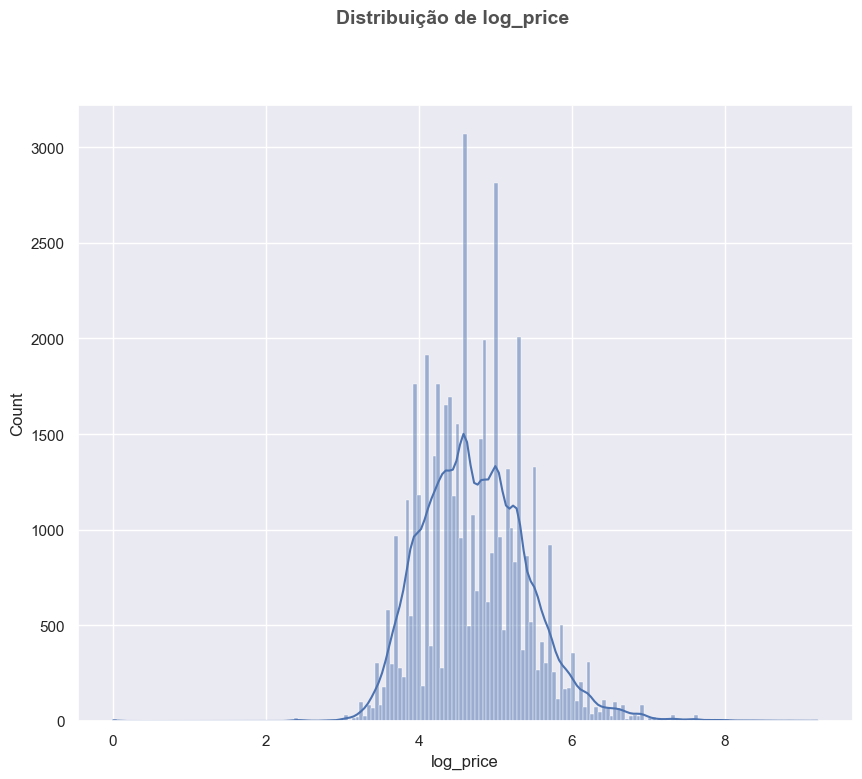

In [38]:
plt.figure(figsize=(10,8))
sns.histplot(df['log_price'], kde=True)
plt.suptitle("Distribuição de log_price", fontsize=14, fontweight="bold", alpha=0.8, y=1)
plt.show()

Em seguida vamos selecionar as variáveis relevantes e dividir nosso conjunto de dados em variáveis indedependentes e dependentes.

In [39]:
features = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
            'disponibilidade_365',
            'bairro_group_Brooklyn', 'bairro_group_Manhattan',
            'bairro_group_Queens', 'bairro_group_Staten Island',
            'room_type_Private room', 'room_type_Shared room']
df_x = df[features]
df_y = df['log_price']

Agora dividimos nosso conjunto de dados em conjuntos de teste e de treino.

In [40]:
x_treino, x_teste, y_treino, y_teste = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

O modelo que usaremos para fazer a previsão é um XGBoost devido à sua capacidade de lidar com dados complexos e não lineares, sua robustez no que diz respeito a outliers e sua capacidade de lidar com grandes conjuntos de dados, além da sua capacidade de controle de overfitting.
Em contrapartida, trata-se de um modelo computacionalmente caro, principalmente com grandes conjuntos de dados, além de requerer o ajuste de hiperparâmetros a fim de se obter o melhor desempenho possível.

In [41]:
dtrain = xgb.DMatrix(x_treino, label=y_treino)
dtest = xgb.DMatrix(x_teste, label=y_teste)
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 1.0,
    'eval_metric': 'rmse'
}
evals = [(dtest, 'eval'), (dtrain, 'train')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=10
)
y_prev = xgb_model.predict(dtest)

[0]	eval-rmse:0.64568	train-rmse:0.66449
[10]	eval-rmse:0.48478	train-rmse:0.49989
[20]	eval-rmse:0.44994	train-rmse:0.46050
[30]	eval-rmse:0.43990	train-rmse:0.44715
[40]	eval-rmse:0.43623	train-rmse:0.44016
[50]	eval-rmse:0.43413	train-rmse:0.43543
[60]	eval-rmse:0.43322	train-rmse:0.43230
[70]	eval-rmse:0.43232	train-rmse:0.42891
[80]	eval-rmse:0.43190	train-rmse:0.42609
[90]	eval-rmse:0.43146	train-rmse:0.42409
[100]	eval-rmse:0.43096	train-rmse:0.42165
[110]	eval-rmse:0.43058	train-rmse:0.41958
[120]	eval-rmse:0.43029	train-rmse:0.41774
[130]	eval-rmse:0.43035	train-rmse:0.41601
[140]	eval-rmse:0.43024	train-rmse:0.41400
[150]	eval-rmse:0.42988	train-rmse:0.41204
[160]	eval-rmse:0.42995	train-rmse:0.41052
[170]	eval-rmse:0.43001	train-rmse:0.40884
[180]	eval-rmse:0.42968	train-rmse:0.40680
[190]	eval-rmse:0.42941	train-rmse:0.40506
[200]	eval-rmse:0.42933	train-rmse:0.40346
[210]	eval-rmse:0.42914	train-rmse:0.40206
[220]	eval-rmse:0.42908	train-rmse:0.40092
[230]	eval-rmse:0.4291

Mesmo que nosso modelo seja conhecido por ser pouco suscetível a overfitting, adicionamos um `early stop` para lidar com esse caso

Logo abaixo, fazemos uma avaliação dos resultados do modelo. Optamos por usar a técnica Mean Absolute Error (MAE), graças à sua interpretação clara e simples, visto que nos permite visualizar o quão distantes as previsões estão, em média, dos valores reais. Essa métrica é robusta a outliers, o que é especialmente útil no nosso caso, já que lidamos com alguns valores extremos na variável price.

Além dela, também usamos R-squared (R²) para avaliar a capacidade do modelo de explicar a variação dos dados. Em outras palavras, ela indica o quanto o modelo consegue explicar a variação dos preços dos imóveis, no nosso estudo de caso, com base nas variáveis independentes. Um valor de R² mais próximo de 1 sugere que o modelo consegue capturar bem a variabilidade dos dados, enquanto valores mais baixos indicam que há espaço para melhorias.

Para complementar a avaliação, adicionamos também o Root Mean Squared Error (RMSE), que nos dá uma ideia da magnitude dos erros ao penalizar mais os erros grandes. Ele é útil para identificar se o modelo está fazendo previsões muito distantes dos valores reais, o que pode ser crítico em um contexto de preços de imóveis. O RMSE é particularmente sensível a outliers, o que ajuda a destacar possíveis problemas nas previsões extremas.

In [44]:
dtest = xgb.DMatrix(x_teste)
y_prev = xgb_model.predict(dtest)
mae = mean_absolute_error(y_teste, y_prev)
r2 = r2_score(y_teste, y_prev)
rmse = np.sqrt(mean_squared_error(y_teste, y_prev))
print(f"MAE: {mae}")
print(f"R² Score: {r2}")
print(f"RMSE: {rmse}")

MAE: 0.31185992886272235
R² Score: 0.5885754977197961
RMSE: 0.4362107968355057


O erro médio entre as previsões e os valores reais é relativamente baixo, indicando boa precisão.

Aproximadamente 59% da variabilidade nos preços foi explicada pelo modelo, sugerindo uma relação moderada entre as variáveis de entrada e o preço do imóvel.

O valor do erro médio é razoavelmente pequeno, reforçando a eficácia do modelo nas previsões.


Além das métricas numéricas, incluímos uma análise visual por meio do Gráfico de Resíduos, que mostra a diferença entre os valores reais e os previstos. Esse gráfico nos permite identificar padrões nos erros, como tendências ou heterocedasticidade, que podem indicar problemas no modelo.

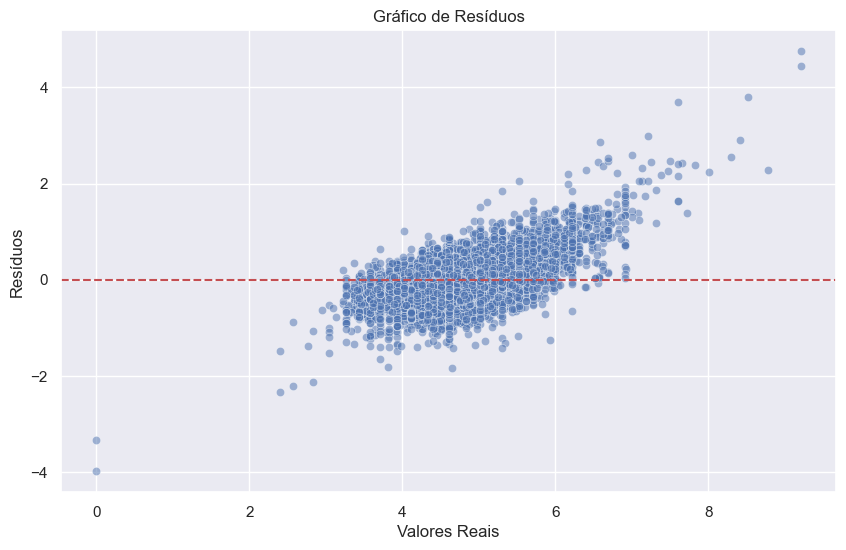

In [45]:
residuos = y_teste - y_prev
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_teste, y=residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Gráfico de Resíduos")
plt.xlabel("Valores Reais")
plt.ylabel("Resíduos")
plt.show()

Por fim, a Distribuição dos Resíduos nos ajuda a entender como os erros estão distribuídos, verificando se eles seguem uma distribuição normal ou se há viés nas previsões.

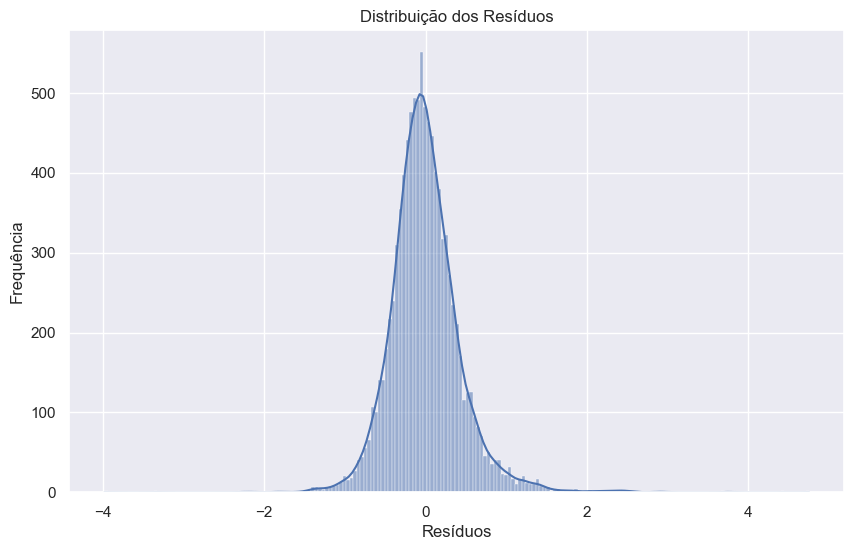

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.show()

#### Qual variável foi mais importante para a previsão do modelo?

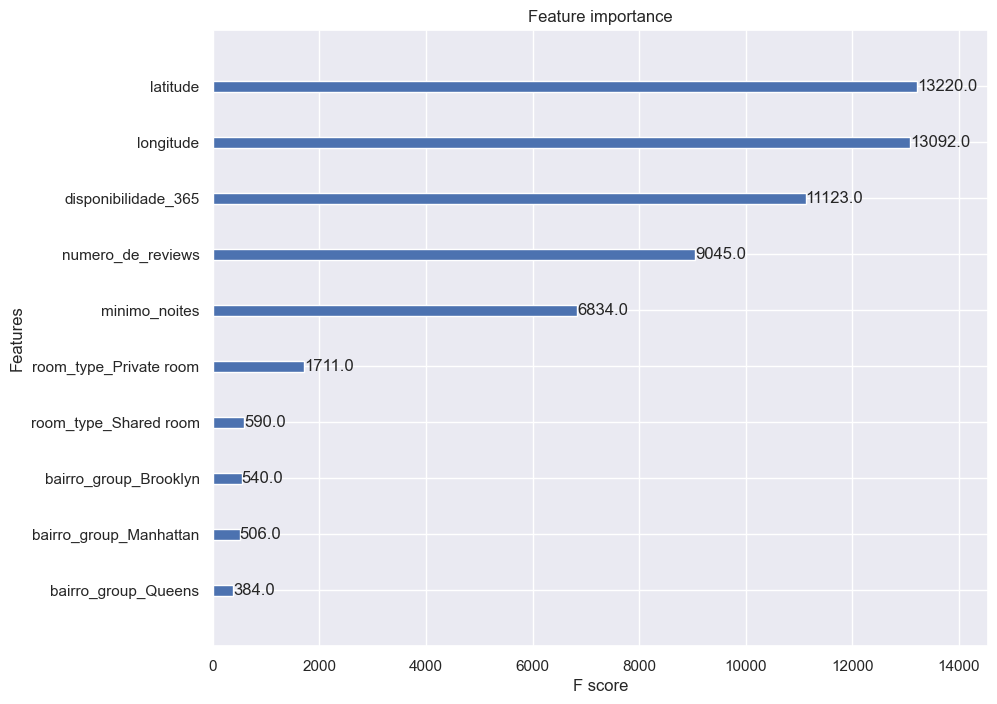

In [47]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

As variáveis mais importantes para determinação do preço por noite do imóveis são exibidas em ordem decrescente no gráfico acima, com destaque para `latitude`, `longitude`, `dispibilidade_365`, `numero_de_reviews` e `minimo_noites`.

## Testando a previsão para um apartamento

Supondo os dados abaixo para um apartamento de teste, podemos sugerir um preço por noite.

In [48]:
imóvel = {
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'disponibilidade_365': 355,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'ultima_review': '2019-05-21'
}

df_imóvel = pd.DataFrame([imóvel])

In [49]:
df_imóvel['bairro'] = df_imóvel['bairro'].astype("category").cat.codes
df_imóvel = pd.get_dummies(df_imóvel, columns=['bairro_group', 'room_type'], drop_first=True)
for col in features:
    if col not in df_imóvel.columns:
        df_imóvel[col] = 0
df_imóvel.head()

,bairro,latitude,longitude,minimo_noites,numero_de_reviews,disponibilidade_365,reviews_por_mes,calculado_host_listings_count,ultima_review,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Private room,room_type_Shared room
0,0,40.75362,-73.98377,1,45,355,0.38,2,2019-05-21,0,0,0,0,0,0


In [50]:
df_imóvel = df_imóvel[features]
df_imóvel.head()

,latitude,longitude,minimo_noites,numero_de_reviews,disponibilidade_365,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Private room,room_type_Shared room
0,40.75362,-73.98377,1,45,355,0,0,0,0,0,0


In [53]:
df_imóvel_dmatrix = xgb.DMatrix(df_imóvel)
previsao = xgb_model.predict(df_imóvel_dmatrix)
print(f'Preço sugerido (em transformação logaritmica): {previsao[0]:.2f}')
preco_estimado = np.expm1(previsao[0])
print(f'Preço sugerido (em valor real): {preco_estimado:.2f}')

Preço sugerido (em transformação logaritmica): 5.44
Preço sugerido (em valor real): 229.79
